# Integrate Samples and Basic Check

## Here I did several things
1. I load all 6 samples, and integrate the raw count into a single table. This will be used for DEG analysis
2. I transformed the raw count by log10(count + 1) to make the gene values into similar scale
3. I selected relatively high expressed genes and variable genes, they are more likely showing sample differences
4. I did PCA using the **remaining genes** and the **log10(count + 1)** value
5. I did sample-sample correlation using the **remaining genes** and the **log10(count + 1)** value

## Important functions

- Handle file paths:
    - pathlib.Path
    - pathlib.Path.glob
- DataFrame calculation
    - pd.DataFrame.mean
    - pd.DataFrame.std
    - np.log10
    - pd.DataFrame.corr
- PCA
    - sklearn.decomposition.PCA
- Plotting
    - sns.jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot
    - sns.scatterplot: https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn.scatterplot
    - sns.clustermap: https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap
    - sns.heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
    - And seaborn package in general: https://seaborn.pydata.org/tutorial.html


In [1]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns  # higher level python plotting package, make plots easily
import matplotlib.pyplot as plt  # basic python plotting package, seaborn is based on matplotlib

## Load samples and create a single table

In [2]:
# change to where you save the samples
sample_dir = '../data/'

In [3]:
sample_dir = pathlib.Path(sample_dir)

sample_counts_path_list = list(sample_dir.glob("*tsv.gz"))
sample_counts_path_list

[PosixPath('../data/forebrain_P0_2.Counts.tsv.gz'),
 PosixPath('../data/forebrain_E10.5_1.Counts.tsv.gz'),
 PosixPath('../data/forebrain_E14.5_2.Counts.tsv.gz'),
 PosixPath('../data/forebrain_P0_1.Counts.tsv.gz'),
 PosixPath('../data/forebrain_E14.5_1.Counts.tsv.gz'),
 PosixPath('../data/forebrain_E10.5_2.Counts.tsv.gz')]

In [4]:
?pathlib.Path

In [5]:
?pathlib.Path.glob

In [6]:
# read one sample for example
pd.read_csv(sample_counts_path_list[0], sep='\t', 
            header=None, index_col=0, names=['gene_id', 'count'], squeeze=True)

# important question: what's the difference between squeeze=True or squeeze=False here? Try it by yourself

gene_id
ENSMUSG00000000001.4     8312
ENSMUSG00000000003.15       0
ENSMUSG00000000028.15     284
ENSMUSG00000000031.16     611
ENSMUSG00000000037.17     142
                         ... 
ENSMUSG00000118636.1        1
ENSMUSG00000118637.1        0
ENSMUSG00000118638.1        0
ENSMUSG00000118639.1        0
ENSMUSG00000118640.1        0
Name: count, Length: 54331, dtype: int64

In [7]:
# read all

sample_data_list = []
for path in sample_counts_path_list:
    # I use the sample name to name the gene count column, so the table col is named by sample
    # this line should be different if your file name is different from mine
    sample_name = '.'.join(path.name.split('.')[:-3]) 
    
    data = pd.read_csv(path,
                       sep='\t',
                       header=None,
                       index_col=0,
                       names=['gene_id', sample_name],
                       squeeze=True)
    sample_data_list.append(data)
    
# create dataframe use all sample
gene_count_table = pd.DataFrame(sample_data_list).T  # what is this .T here? 

In [8]:
gene_count_table

,forebrain_P0_2,forebrain_E10.5_1,forebrain_E14.5_2,forebrain_P0_1,forebrain_E14.5_1,forebrain_E10.5_2
gene_id,,,,,,
ENSMUSG00000000001.4,8312,16156,9459,8661,10751,14368
ENSMUSG00000000003.15,0,0,0,0,0,0
ENSMUSG00000000028.15,284,3997,1038,230,1428,3666
ENSMUSG00000000031.16,611,4061,909,578,1059,4205
ENSMUSG00000000037.17,142,355,225,181,289,283
...,...,...,...,...,...,...
ENSMUSG00000118636.1,1,2,0,3,2,3
ENSMUSG00000118637.1,0,0,0,0,0,0
ENSMUSG00000118638.1,0,0,0,0,0,1


In [9]:
gene_count_table.to_csv('gene_raw_count_table.csv.gz')

## Calculate log10(n+1) and filter out low expressed or small difference genes

### Why log10(n+1) transform of the raw count here?
Try google, or we can discuss later

In [10]:
gene_lg1p_table = np.log10(gene_count_table + 1)
gene_lg1p_table.head()

,forebrain_P0_2,forebrain_E10.5_1,forebrain_E14.5_2,forebrain_P0_1,forebrain_E14.5_1,forebrain_E10.5_2
gene_id,,,,,,
ENSMUSG00000000001.4,3.919758,4.208361,3.975891,3.937618,4.031489,4.157427
ENSMUSG00000000003.15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028.15,2.454845,3.601843,3.016616,2.363612,3.155032,3.564311
ENSMUSG00000000031.16,2.786751,3.608740,2.959041,2.762679,3.025306,3.623869
ENSMUSG00000000037.17,2.155336,2.551450,2.354108,2.260071,2.462398,2.453318


[Text(27.0, 0.5, 'sd'), Text(0.5, 32.99999999999995, 'mean')]

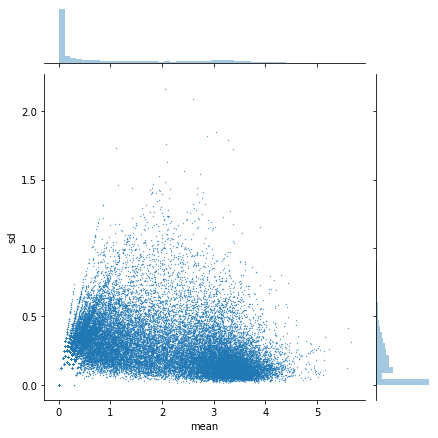

In [11]:
# mean and std expression across samples
gene_mean = gene_lg1p_table.mean(axis=1)
gene_sd = gene_lg1p_table.std(axis=1)

# let's make our first plot!
g = sns.jointplot(x=gene_mean, y=gene_sd, kind='scatter', s=0.1)
g.ax_joint.set(xlabel='mean', ylabel='sd')

# this is a distribution plot
# You can see there is a lot of dots in (0, 0) as shown by side distribution plot
# this means a lot of gene is not detected at all, 
# we should remove these genes, because they provide no info

### IMPORTANT

Here I filtered very low expression gene and gene's showing very little changes among samples. This is just intend to roughly find out potential interesting genes for following calculation. But in DEG analysis, we have more sophesticated filtering. Here the filter do not apply to further DEG analysis!

In [12]:
filter_series = (gene_mean > 0.2) & (gene_sd > 0.2)

# we created a bool series to easily select genes based on combination of criteria
filter_series

gene_id
ENSMUSG00000000001.4     False
ENSMUSG00000000003.15    False
ENSMUSG00000000028.15     True
ENSMUSG00000000031.16     True
ENSMUSG00000000037.17    False
                         ...  
ENSMUSG00000118636.1      True
ENSMUSG00000118637.1     False
ENSMUSG00000118638.1     False
ENSMUSG00000118639.1     False
ENSMUSG00000118640.1     False
Length: 54331, dtype: bool

In [13]:
gene_lg1p_table_filtered = gene_lg1p_table[filter_series].copy()

print('before', gene_lg1p_table.shape[0])
print('after', gene_lg1p_table_filtered.shape[0])

gene_lg1p_table_filtered.head()

before 54331
after 17489


,forebrain_P0_2,forebrain_E10.5_1,forebrain_E14.5_2,forebrain_P0_1,forebrain_E14.5_1,forebrain_E10.5_2
gene_id,,,,,,
ENSMUSG00000000028.15,2.454845,3.601843,3.016616,2.363612,3.155032,3.564311
ENSMUSG00000000031.16,2.786751,3.608740,2.959041,2.762679,3.025306,3.623869
ENSMUSG00000000049.11,0.845098,0.000000,0.698970,0.845098,0.000000,0.000000
ENSMUSG00000000058.6,3.040602,2.477121,2.808211,3.092721,2.830589,2.399674
ENSMUSG00000000093.6,1.579784,2.460898,1.623249,1.579784,1.602060,2.294466


[Text(27.0, 0.5, 'sd'), Text(0.5, 32.99999999999995, 'mean')]

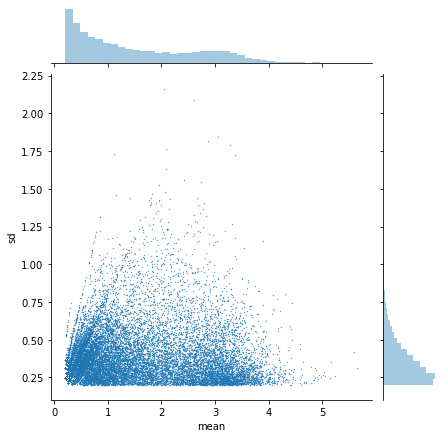

In [14]:
# the distribution after filter
gene_mean = gene_lg1p_table_filtered.mean(axis=1)
gene_sd = gene_lg1p_table_filtered.std(axis=1)

# plot again
g = sns.jointplot(x=gene_mean, y=gene_sd, kind='scatter', s=0.1)
g.ax_joint.set(xlabel='mean', ylabel='sd')

The following 

## Calculate PCA and plot it

Watch this video about PCA first: https://www.youtube.com/watch?v=FgakZw6K1QQ

In [15]:
from sklearn.decomposition import PCA

In [16]:
?PCA

In [17]:
# here is how to use sklearn to run PCA

# first, you need to create a PCA object

pca = PCA(
    n_components=2,  # we want to take PC1 and PC2, but this can be none also
    copy=True,
    whiten=False,  # keep everything else default
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    random_state=None,
)

In [18]:
# then we fit the PCA object, it now contain all PC informations
pca.fit(gene_lg1p_table_filtered)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
print(f'PC1 explained {pca.explained_variance_ratio_[0]} variance')
print(f'PC2 explained {pca.explained_variance_ratio_[1]} variance')
print(pca.explained_variance_ratio_)

PC1 explained 0.8910790231453449 variance
PC2 explained 0.07855403210505224 variance
[0.89107902 0.07855403]


In [20]:
pc_df = pd.DataFrame(pca.components_, index=['PC1', 'PC2'], columns=gene_lg1p_table_filtered.columns).T
pc_df

,PC1,PC2
forebrain_P0_2,0.418095,-0.417247
forebrain_E10.5_1,0.391765,0.558089
forebrain_E14.5_2,0.416105,-0.139170
forebrain_P0_1,0.410356,-0.384028
forebrain_E14.5_1,0.422004,-0.126273
forebrain_E10.5_2,0.389993,0.575892


In [21]:
# pd.Index.map is just like pd.DataFrame.apply, but for index of the table
pc_df['Dev. Time'] = pc_df.index.map(lambda i: i.split('_')[1])

This PC plot shows us E10.5 is very different from E14.5 and P0.
Replicates are closer than time points, which is good.


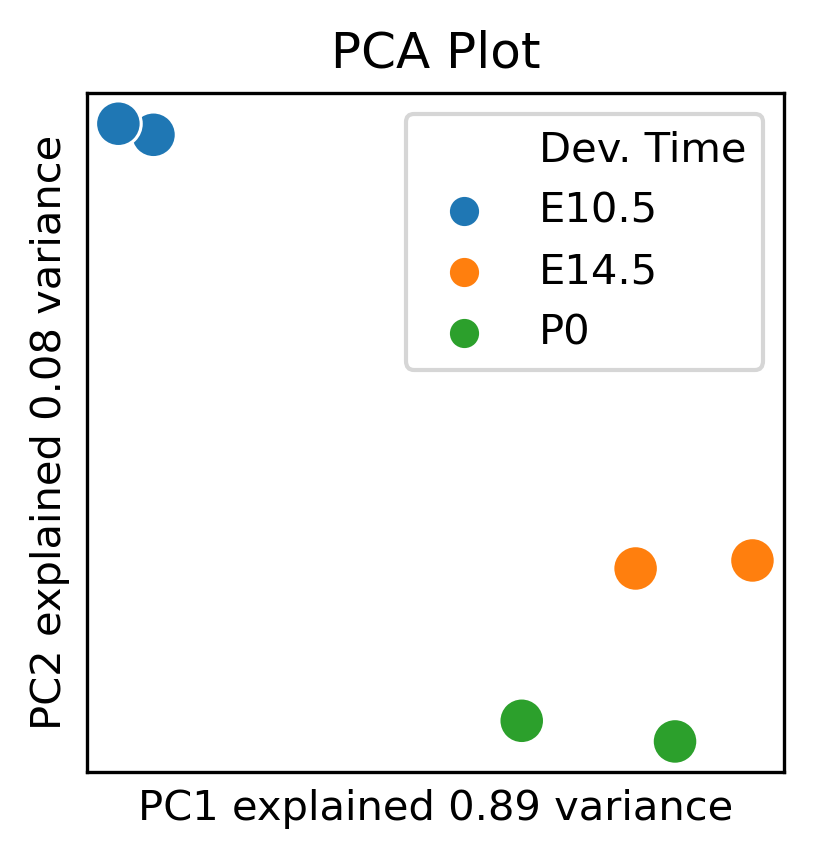

In [22]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

# plot scatter plots
sns.scatterplot(ax=ax, 
                data=pc_df, 
                x='PC1', 
                y='PC2', 
                hue='Dev. Time',
                hue_order=['E10.5', 'E14.5', 'P0'],
                s=120  # make size bigger
               )

ax.set(xlabel=f'PC1 explained {pca.explained_variance_ratio_[0]:.2f} variance',
       ylabel=f'PC2 explained {pca.explained_variance_ratio_[1]:.2f} variance',
       xticks=[], yticks=[],
       title='PCA Plot')
print('This PC plot shows us E10.5 is very different from E14.5 and P0.\n'
      'Replicates are closer than time points, which is good.')

fig.savefig('PCA Plot.pdf')

## Calculate sample-sample correlation and plot it

In [23]:
# pearson corr. between each sample
sample_corr = gene_lg1p_table_filtered.corr(method='pearson')
sample_corr

,forebrain_P0_2,forebrain_E10.5_1,forebrain_E14.5_2,forebrain_P0_1,forebrain_E14.5_1,forebrain_E10.5_2
forebrain_P0_2,1.000000,0.758916,0.920107,0.966121,0.924091,0.753043
forebrain_E10.5_1,0.758916,1.000000,0.844561,0.770030,0.849732,0.972706
forebrain_E14.5_2,0.920107,0.844561,1.000000,0.933294,0.967076,0.836623
forebrain_P0_1,0.966121,0.770030,0.933294,1.000000,0.926679,0.762338
forebrain_E14.5_1,0.924091,0.849732,0.967076,0.926679,1.000000,0.841585
forebrain_E10.5_2,0.753043,0.972706,0.836623,0.762338,0.841585,1.000000



The correlations between replicates are all high 0.97, means the replicates within timepoint are very similar, data is in good quality;
The correlations between closer time points (P0 vs E14.5; E14.5 vs E10.5) are higher than P0 vs E10.5, which also make sense;
The P0 vs E14.5 correlations are higher than E14.5 vs E10.5, which provides similar evidence as the PCA analysis



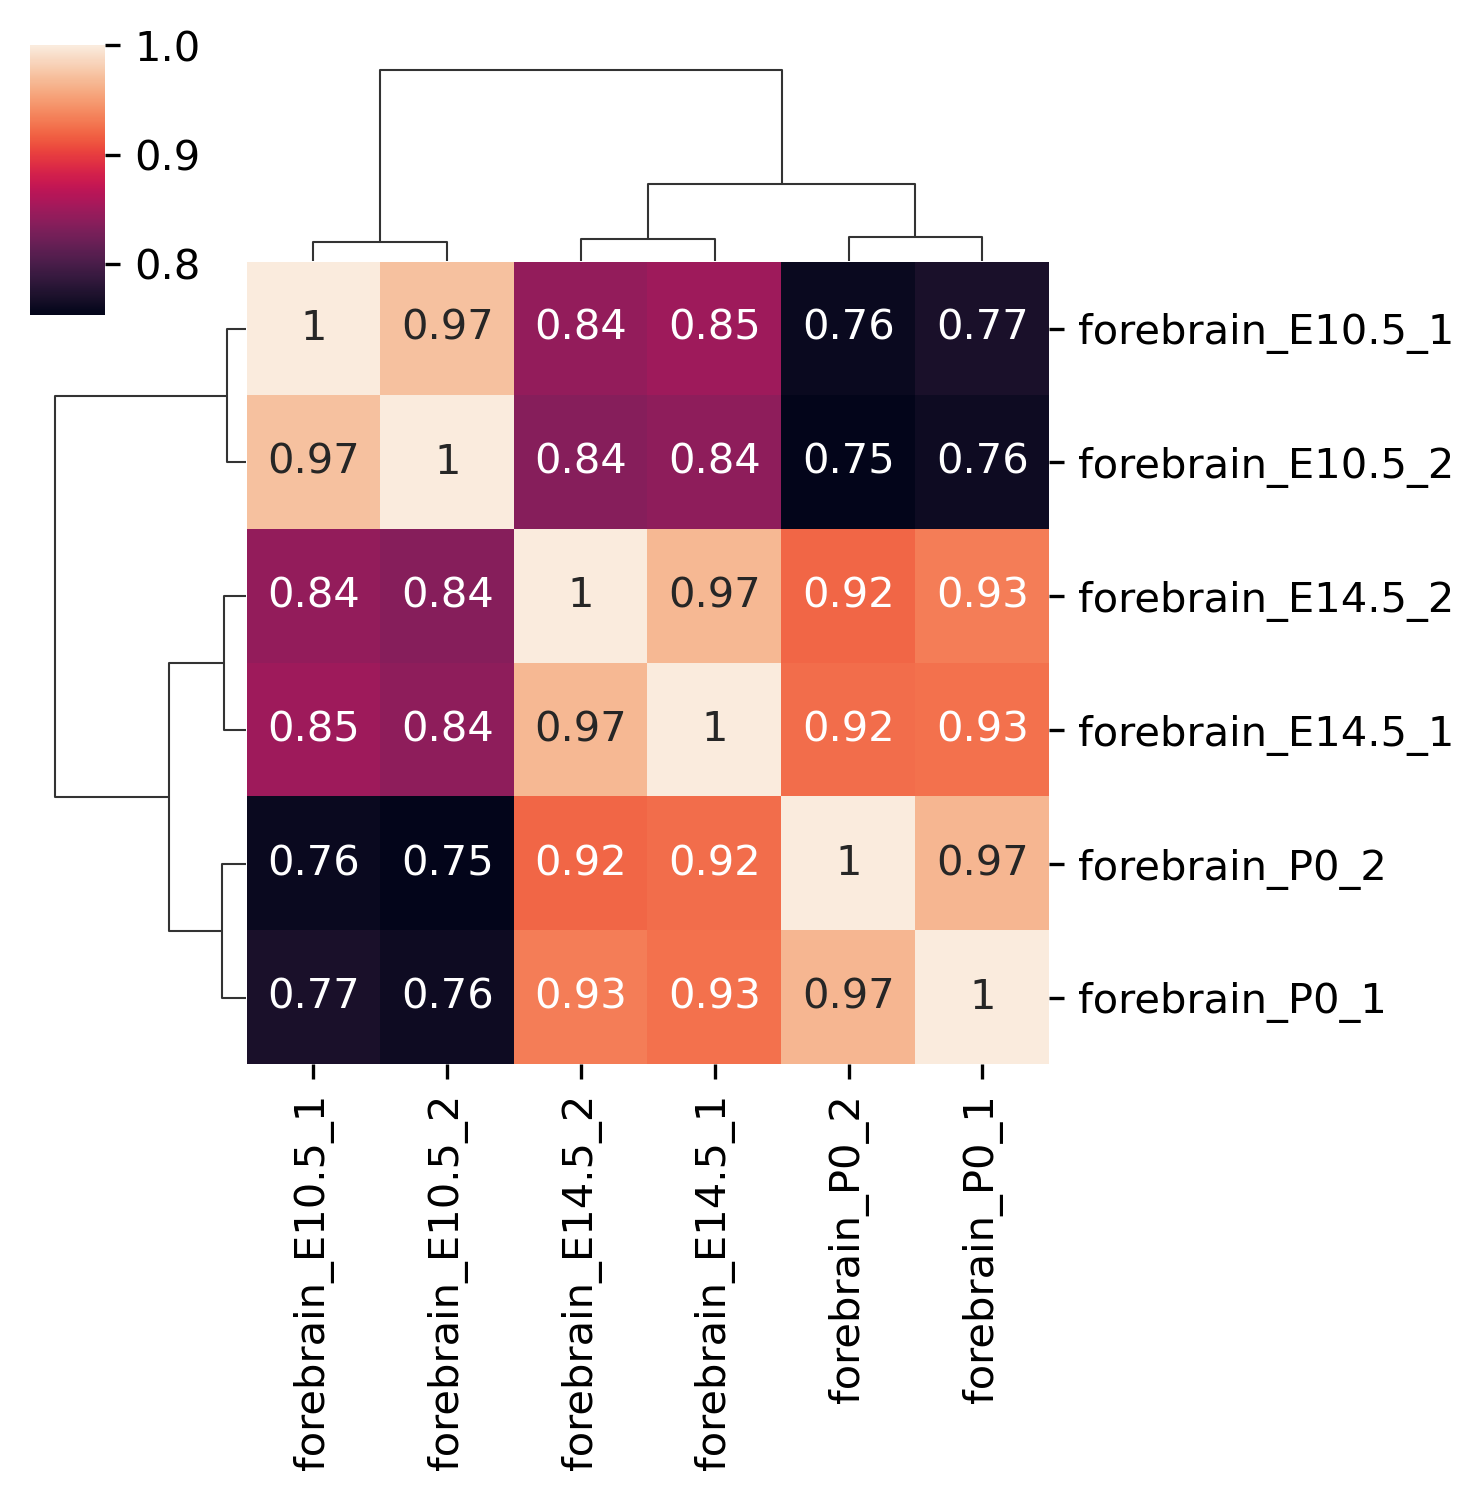

In [24]:
g = sns.clustermap(sample_corr, figsize=(5, 5),
                   annot=True)
g.fig.set(dpi=300)

# interpretation
print("""
The correlations between replicates are all high 0.97, means the replicates within timepoint are very similar, data is in good quality;
The correlations between closer time points (P0 vs E14.5; E14.5 vs E10.5) are higher than P0 vs E10.5, which also make sense;
The P0 vs E14.5 correlations are higher than E14.5 vs E10.5, which provides similar evidence as the PCA analysis
""")
g.fig.savefig('Correlation Heatmap.pdf')